![Sahabat Tani Group](https://i.imgur.com/BAu0r90.png)

# Training Model

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/valselt/sahabat-tani-group)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Check GPU

Don't forget to use PyTorch with CUDA-Enabled


In [1]:
!nvidia-smi

Thu Nov 14 15:24:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   72C    P5             N/A /   18W |     799MiB /   4096MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
#limit vram usage to 50%
torch.cuda.set_per_process_memory_fraction(0.5, 0)

In [4]:
import os
HOME = os.getcwd()
print(HOME)

c:\Users\ivana\Music


## Install YOLO11 via Ultralytics

In [5]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.31  Python-3.9.20 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)
Setup complete  (12 CPUs, 15.9 GB RAM, 198.1/231.8 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [6]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://cdn.britannica.com/16/187216-050-CB57A09B/tomatoes-tomato-plant-Fruit-vegetable.jpg' save=True

Ultralytics 8.3.31 🚀 Python-3.9.20 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

Found https://cdn.britannica.com/16/187216-050-CB57A09B/tomatoes-tomato-plant-Fruit-vegetable.jpg locally at tomatoes-tomato-plant-Fruit-vegetable.jpg
image 1/1 c:\Users\ivana\Music\tomatoes-tomato-plant-Fruit-vegetable.jpg: 448x640 4 apples, 2 oranges, 60.6ms
Speed: 10.4ms preprocess, 60.6ms inference, 322.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

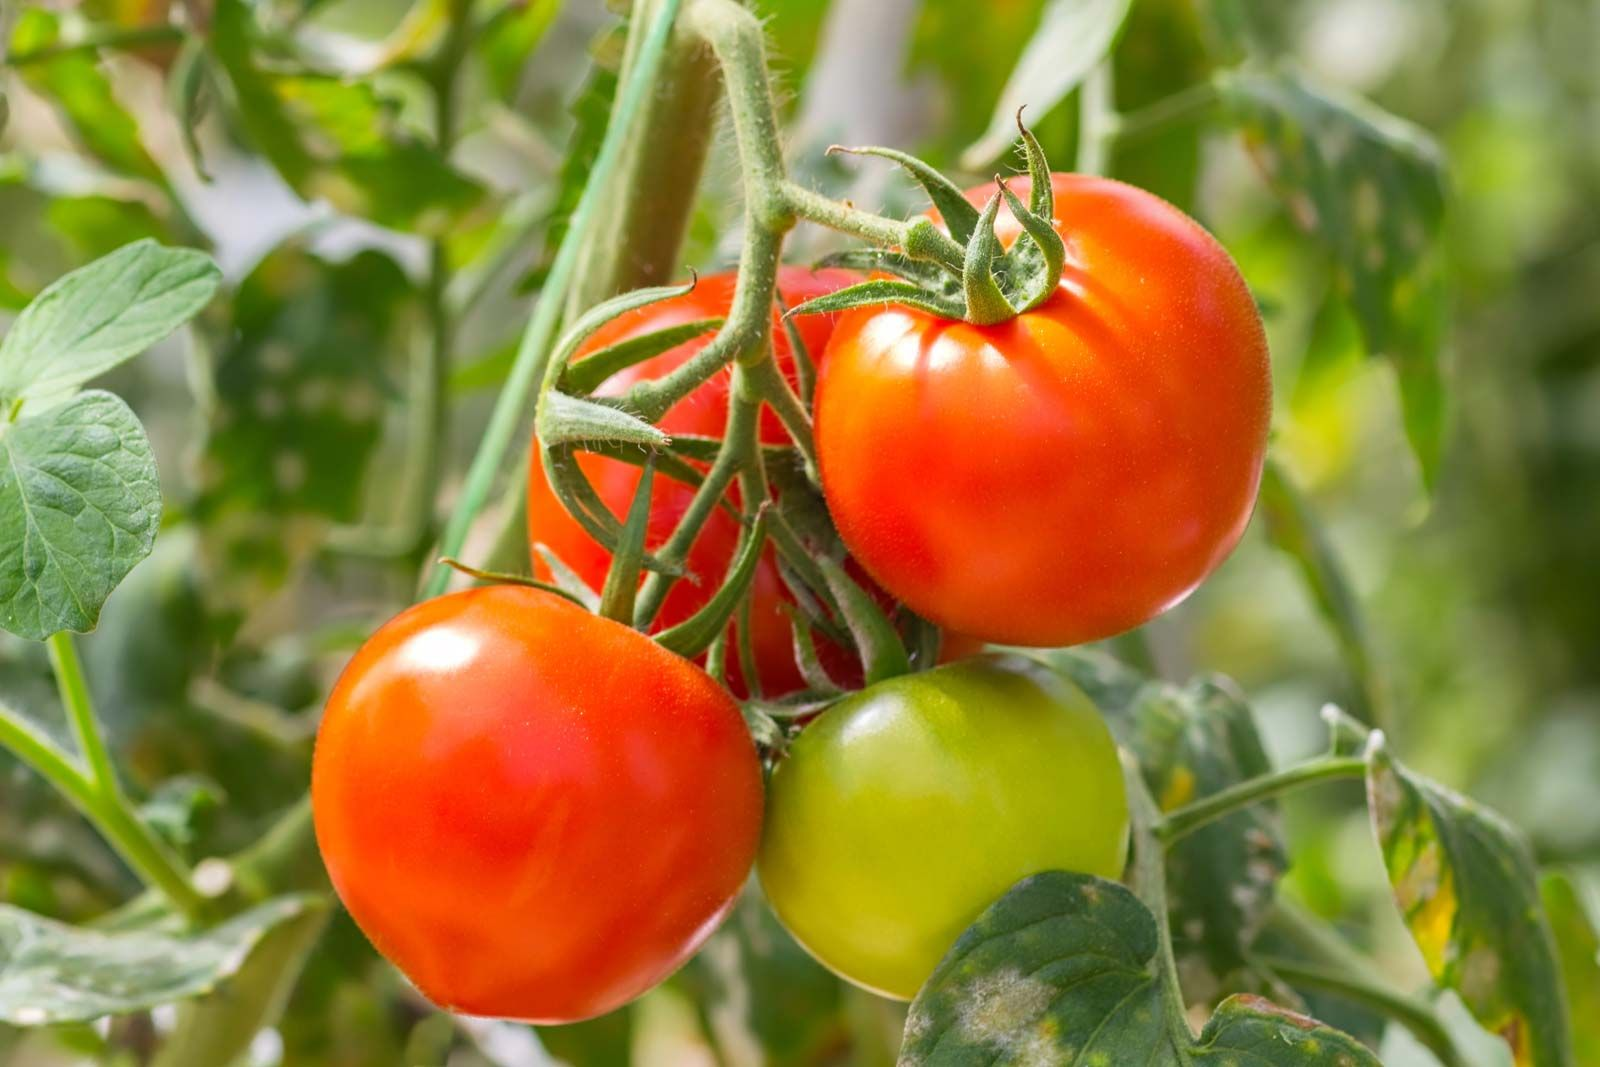

In [7]:
from IPython.display import Image as IPyImage

path = f'{HOME}/tomatoes-tomato-plant-Fruit-vegetable.jpg'

IPyImage(filename=path, width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [9]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open('tomatoes-tomato-plant-Fruit-vegetable.jpg')
result = model.predict(image, conf=0.25)[0]


0: 448x640 4 apples, 2 oranges, 15.9ms
Speed: 0.0ms preprocess, 15.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [10]:
result.boxes.xyxy

tensor([[ 310.2375,  578.6124,  765.0597, 1026.9462],
        [ 756.1742,  659.5992, 1129.7657, 1001.0761],
        [ 807.2299,  172.3991, 1275.3730,  653.7134],
        [ 805.9601,  168.9722, 1274.9563,  652.8695],
        [ 525.8770,  262.9629,  948.7880,  681.7675],
        [ 530.1852,  171.5590, 1271.2657,  667.4625]], device='cuda:0')

In [12]:
result.boxes.conf

tensor([0.8435, 0.7534, 0.4767, 0.4640, 0.4028, 0.2903], device='cuda:0')

In [13]:
result.boxes.cls

tensor([49., 47., 47., 49., 47., 47.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [14]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

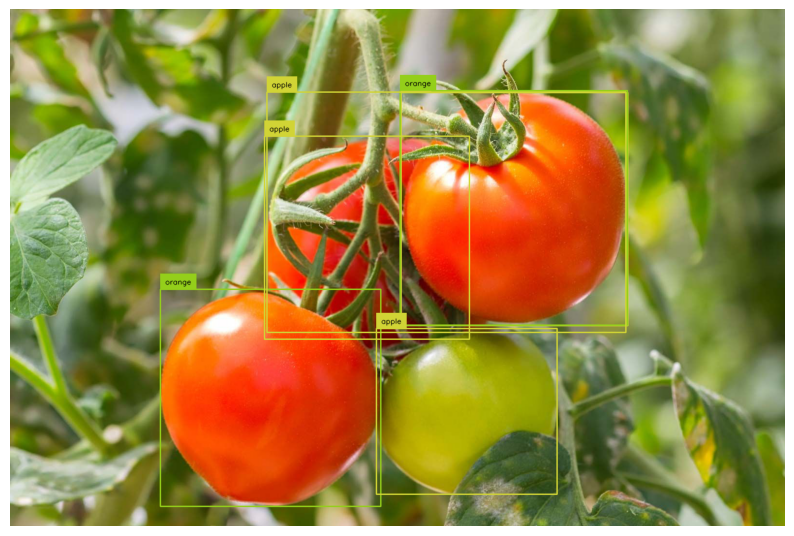

In [15]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

**API KEYS**
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy` on the private key. This will place your private key in the clipboard.
- Place it in ROBOFLOW_API_KEY line below

In [16]:
from getpass import getpass

ROBOFLOW_API_KEY = getpass("Enter API KEY: ")
print("API Key successfully stored secretly 🤫👁️❗.")


API Key successfully stored secretly 🤫👁️❗.


In [18]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from roboflow import Roboflow

rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("penelitian-lpgmn")
project = workspace.project("tomato-detection-fresh-or-rotten-using-yolov8")
version = project.version(1)
dataset = version.download("yolov11")

The syntax of the command is incorrect.


[WinError 2] The system cannot find the file specified: 'c:\\Users\\ivana\\Music/datasets'
c:\Users\ivana\Music
loading Roboflow workspace...
loading Roboflow project...


## Custom Training

In [19]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True device=0


c:\Users\ivana\Music
^C


**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1731070058.ab98371559b1.2537.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


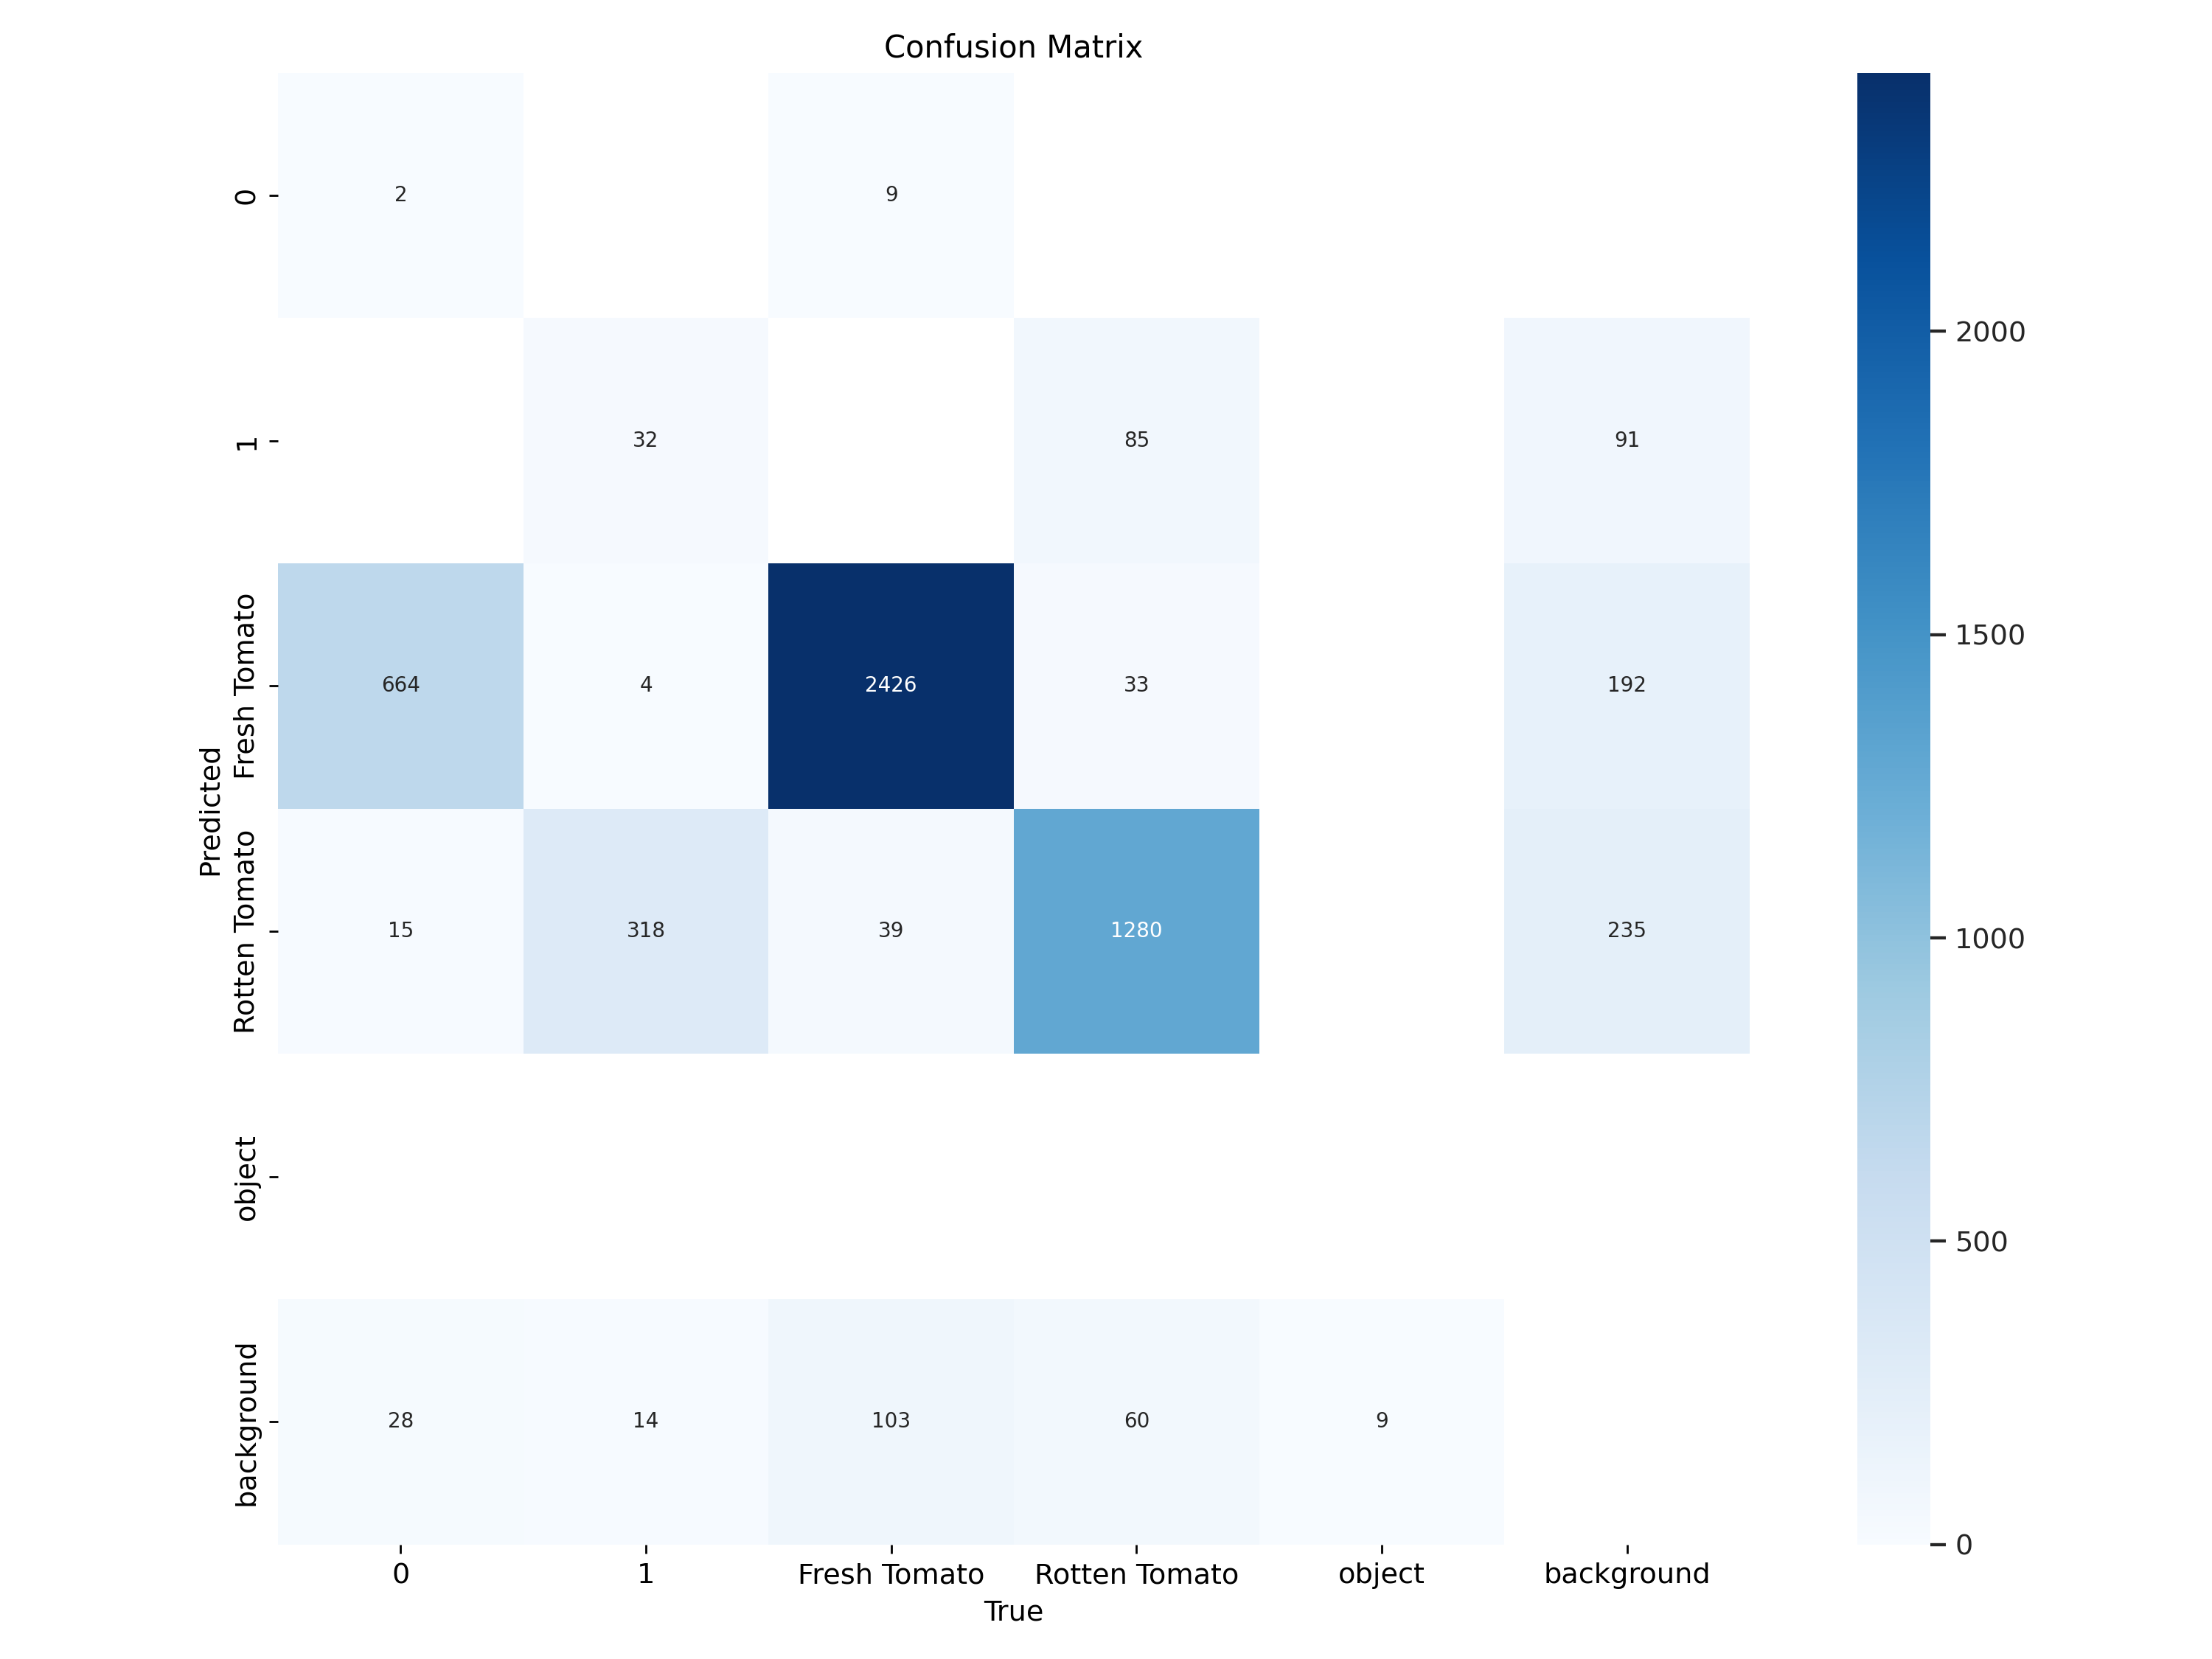

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

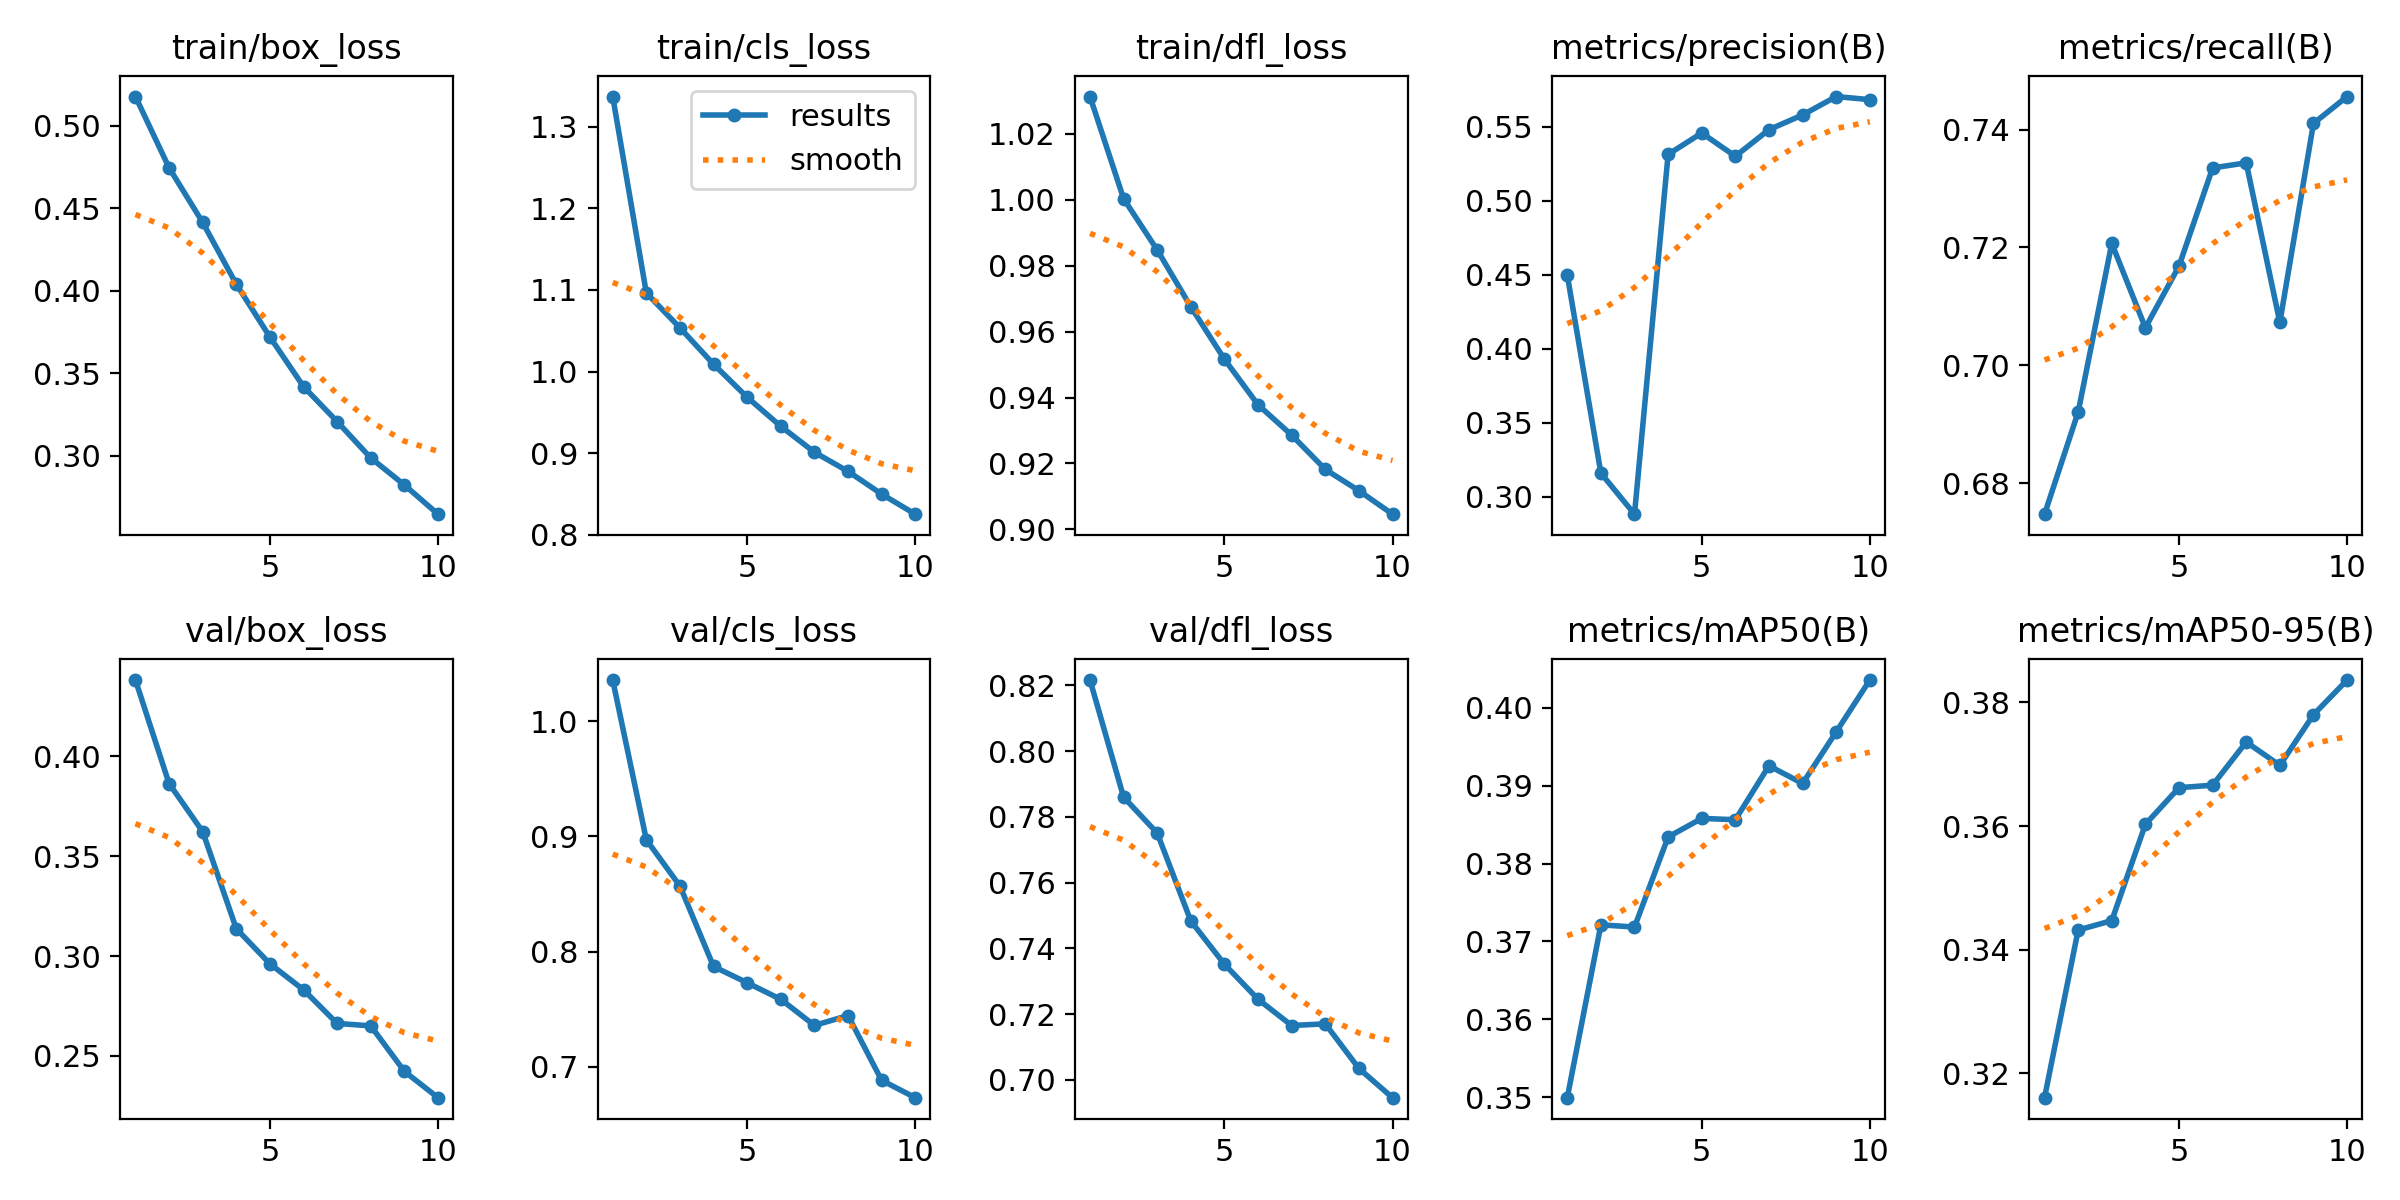

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

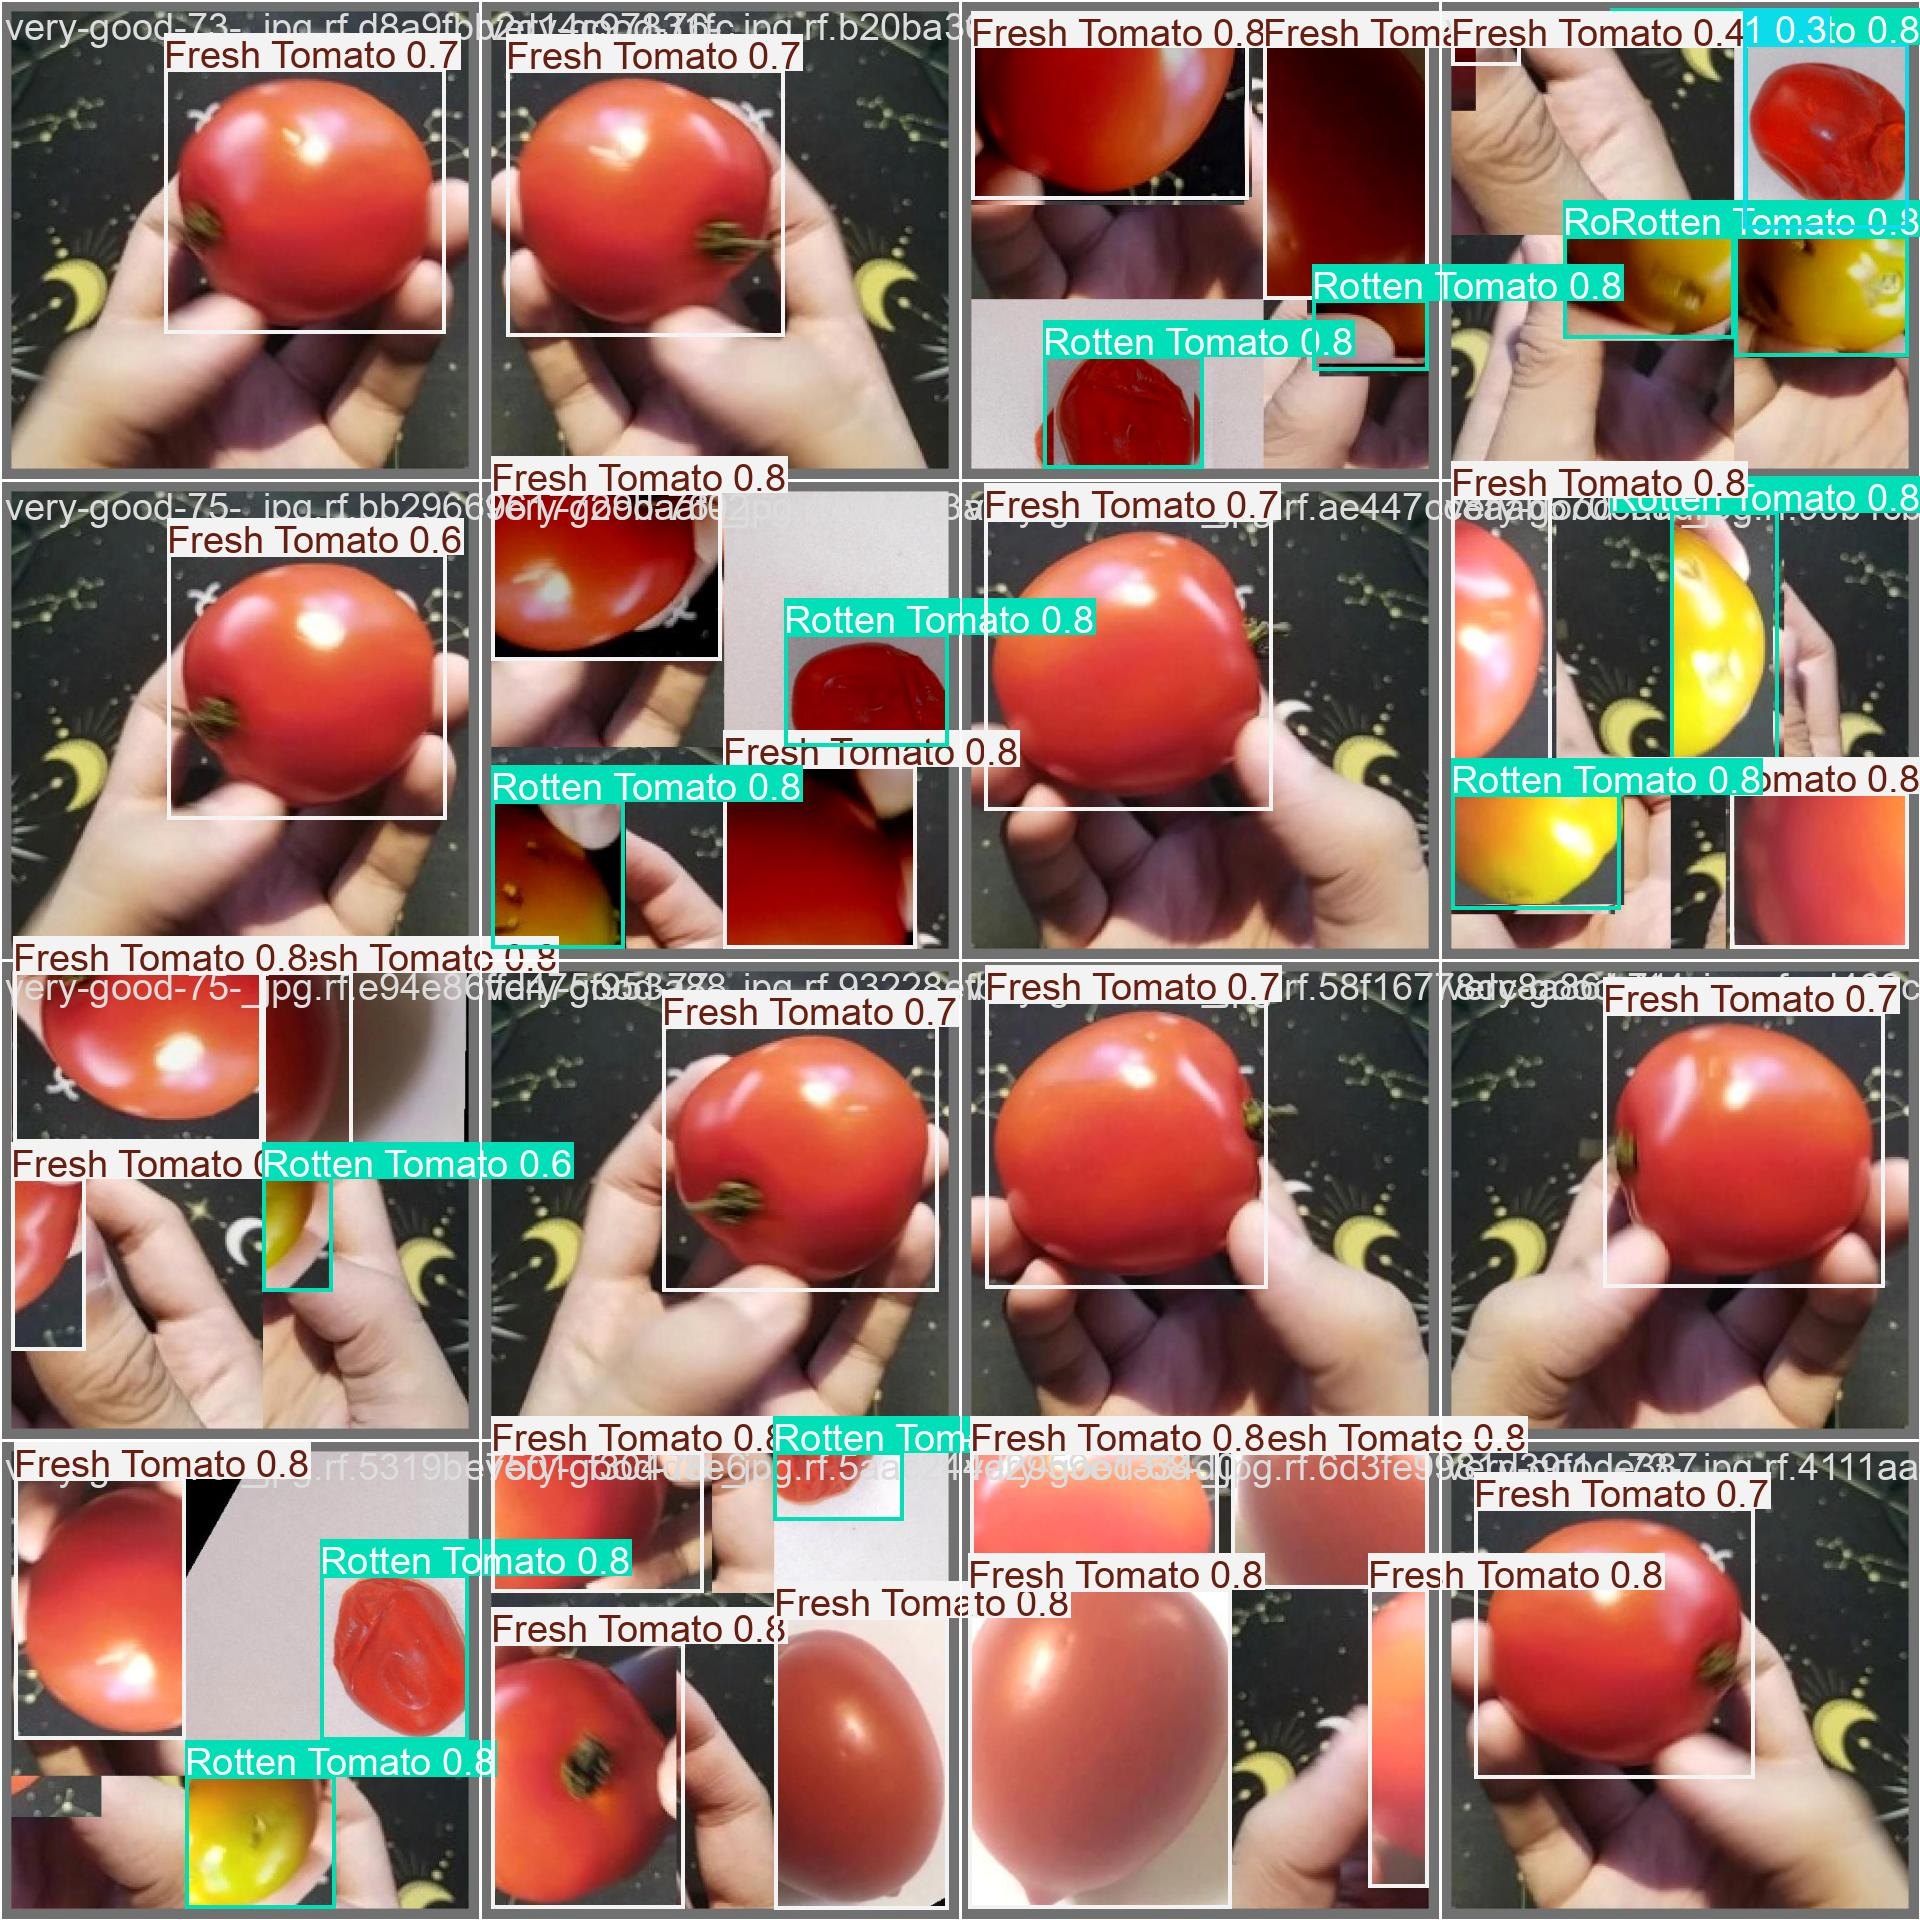

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/valid/labels.cache... 1969 images, 9 backgrounds, 0 corrupt: 100% 1969/1969 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 206, len(boxes) = 5121. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 124/124 [00:31<00:00,  3.98it/s]
                   all       1969       5121      0.568      0.746      0.404      0.384
                     0        347        709       0.21      0.882      0.211      0.198
                     1        250        368      0.199      0.938      0.218     

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs

image 1/987 /content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/test/images/001_jpg.rf.2c6caa773f57268c536aa58a1f38f2b3.jpg: 640x640 5 Fresh Tomatos, 15.6ms
image 2/987 /content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/test/images/002_jpg.rf.a95a83efa76cbbc8ce7a0883681c9fe7.jpg: 640x640 6 Fresh Tomatos, 15.6ms
image 3/987 /content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/test/images/009_jpg.rf.913bd13728fc3ab8e8760379c2e711f6.jpg: 640x640 2 Fresh Tomatos, 2 Rotten Tomatos, 15.6ms
image 4/987 /content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/test/images/009_jpg.rf.fa415a8533e4098ccf78d84ba9d5f4cf.jpg: 640x640 1 Fresh Tomato, 15.5ms
image 5/987 /content/datasets/Tomato-Detection-Fresh-or-Rotten-using-YOLOv8-1/test/images/011_jpg.rf.3dddd5168296090fe68c606d366c9ec

**NOTE:** Let's take a look at few results.

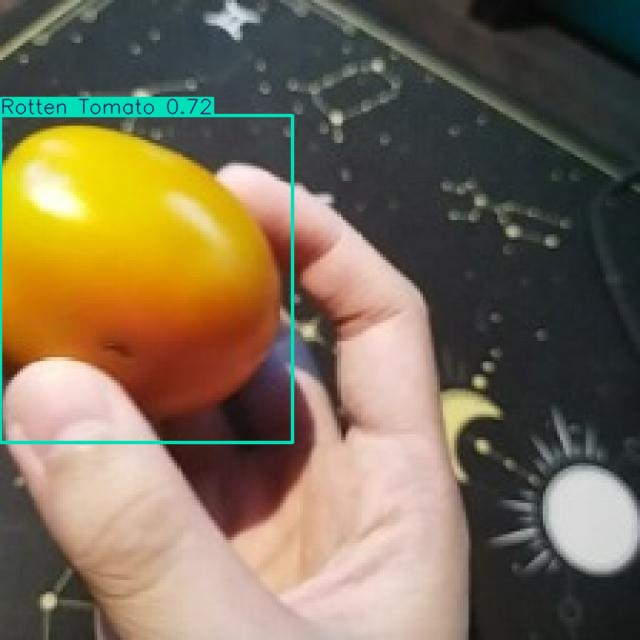

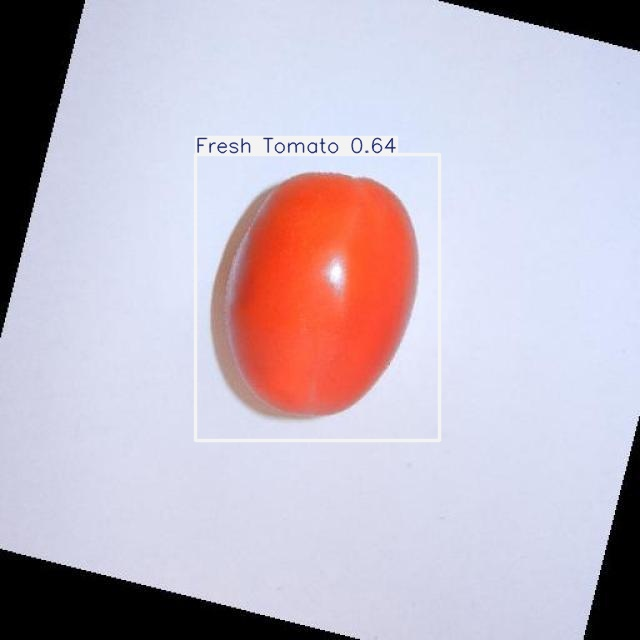

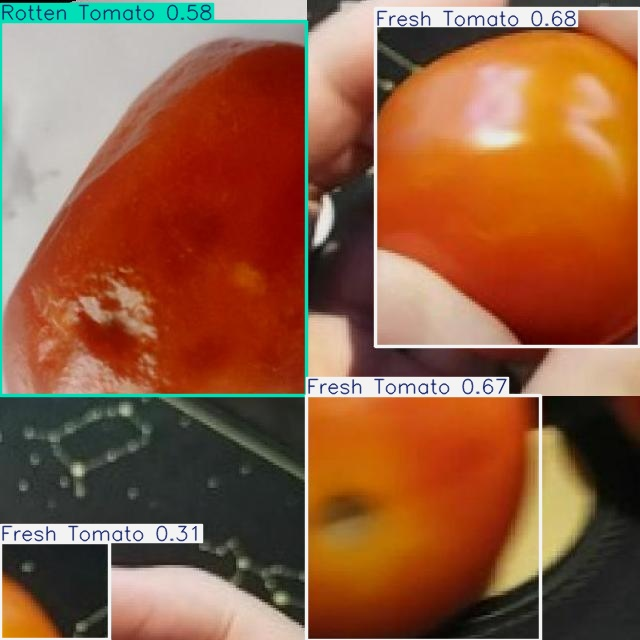

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
